# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [6]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

C:\Users\lavre\AppData\Local\Temp\ipykernel_16760\4113099837.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
C:\Users\lavre\AppData\Local\Temp\ipykernel_16760\4113099837.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shap

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])
# W = 0.001 * np.random.randn(3, 4)
#
# print(X@W)
assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_layer1
Gradient check passed!
Checking gradient for B_layer1
Gradient check passed!
Checking gradient for W_layer2
Gradient check passed!
Checking gradient for B_layer2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_layer1
Gradient check passed!
Checking gradient for B_layer1
Gradient check passed!
Checking gradient for W_layer2
Gradient check passed!
Checking gradient for B_layer2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-5)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

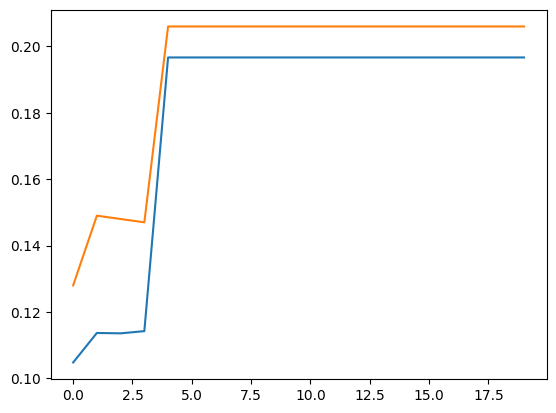

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [18]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model1 = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model1, dataset, SGD(), learning_rate_decay=0.99, learning_rate=1e-2)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

epoch 0 Loss: 2.230052, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 1 Loss: 2.302362, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 2 Loss: 2.383918, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 3 Loss: 2.117315, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 4 Loss: 2.320605, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 5 Loss: 2.209835, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 6 Loss: 2.243155, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 7 Loss: 2.424083, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 8 Loss: 2.148015, Train accuracy: 0.202444, val accuracy: 0.209000
epoch 9 Loss: 1.984886, Train accuracy: 0.227111, val accuracy: 0.227000
epoch 10 Loss: 2.128884, Train accuracy: 0.248556, val accuracy: 0.250000
epoch 11 Loss: 2.058508, Train accuracy: 0.267556, val accuracy: 0.267000
epoch 12 Loss: 2.004089, Train accuracy: 0.277222, val accuracy: 0.275000


KeyboardInterrupt: 

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [19]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-6)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

epoch 0 Loss: 2.264592, Train accuracy: 0.196667, val accuracy: 0.206000
epoch 1 Loss: 1.900754, Train accuracy: 0.409222, val accuracy: 0.400000
epoch 2 Loss: 1.634913, Train accuracy: 0.522667, val accuracy: 0.526000


KeyboardInterrupt: 

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy
loss_history, train_history, val_history = trainer.fit()

Loss: 2.331274, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319712, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319449, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.316003, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310592, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.317842, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.255885, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.210839, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.226207, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.327397, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.976307, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.911775, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.089181, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.539881, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.526519, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.663507, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [16]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less
biggest_train_accuracy = 0
best_hyperparametrs = {"learning_rate" : 0, "regularization" : 0, "optimizer" : None, "batch_size" : 0, "hidden_layer_size" : 0, "learning_rate_decay" : 0}

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
regularizations = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
optimizers = [SGD(), MomentumSGD()]
batch_sizes = list(range(1, data_size + 1))
hidden_layer_sizes = [5, 15, 30, 50, 100, 200]
learning_rate_decays = [0.99, 1]
for learning_rate in learning_rates:
    for regularization in regularizations:
        for optimizer in optimizers:
            for batch_size in batch_sizes:
                for hidden_layer_size in hidden_layer_sizes:
                    for learning_rate_decay in learning_rate_decays:
                        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = regularization)
                        dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
                        # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
                        trainer = Trainer(model, dataset, optimizer, learning_rate=learning_rate, num_epochs=20, batch_size=batch_size)

                        loss_history, train_history, val_history = trainer.fit()

                        if train_history[-1] > biggest_train_accuracy or train_history[-1] == 1.0:
                            biggest_train_accuracy = train_history[-1]
                            best_hyperparametrs['learning_rate'] = learning_rate
                            best_hyperparametrs['regularization'] = regularization
                            best_hyperparametrs['optimizer'] = optimizer
                            best_hyperparametrs['batch_size'] = batch_size
                            best_hyperparametrs['hidden_layer_size'] = hidden_layer_size
                            best_hyperparametrs['learning_rate_decay'] = learning_rate_decay
                            print(biggest_train_accuracy, best_hyperparametrs)
print(biggest_train_accuracy, best_hyperparametrs)

Loss: 2.316270, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301264, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.269199, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.331335, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.241761, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.228658, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.347905, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.203489, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272135, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.361365, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.266053, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.262750, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.145795, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.134840, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.387288, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.114597, Train acc

KeyboardInterrupt: 

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [12]:
learning_rate = 1e-2
regularization = 0.00001
optimizer = MomentumSGD()
batch_size = 5
hidden_layer_size = 200
learning_rate_decay = 0.99

dataset = Dataset(train_X, train_y, val_X, val_y)

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = regularization)
trainer = Trainer(model, dataset, optimizer, learning_rate=learning_rate, num_epochs=8, batch_size=batch_size)

loss_history, train_history, val_history = trainer.fit()

epoch 0 Loss: 1.722223, Train accuracy: 0.495111, val accuracy: 0.496000
epoch 1 Loss: 0.815678, Train accuracy: 0.590111, val accuracy: 0.572000
epoch 2 Loss: 1.310658, Train accuracy: 0.624444, val accuracy: 0.594000
epoch 3 Loss: 2.328704, Train accuracy: 0.629222, val accuracy: 0.596000
epoch 4 Loss: 0.139687, Train accuracy: 0.733111, val accuracy: 0.679000
epoch 5 Loss: 2.302580, Train accuracy: 0.674889, val accuracy: 0.634000
epoch 6 Loss: 1.539629, Train accuracy: 0.712333, val accuracy: 0.636000
epoch 7 Loss: 0.426865, Train accuracy: 0.704667, val accuracy: 0.642000


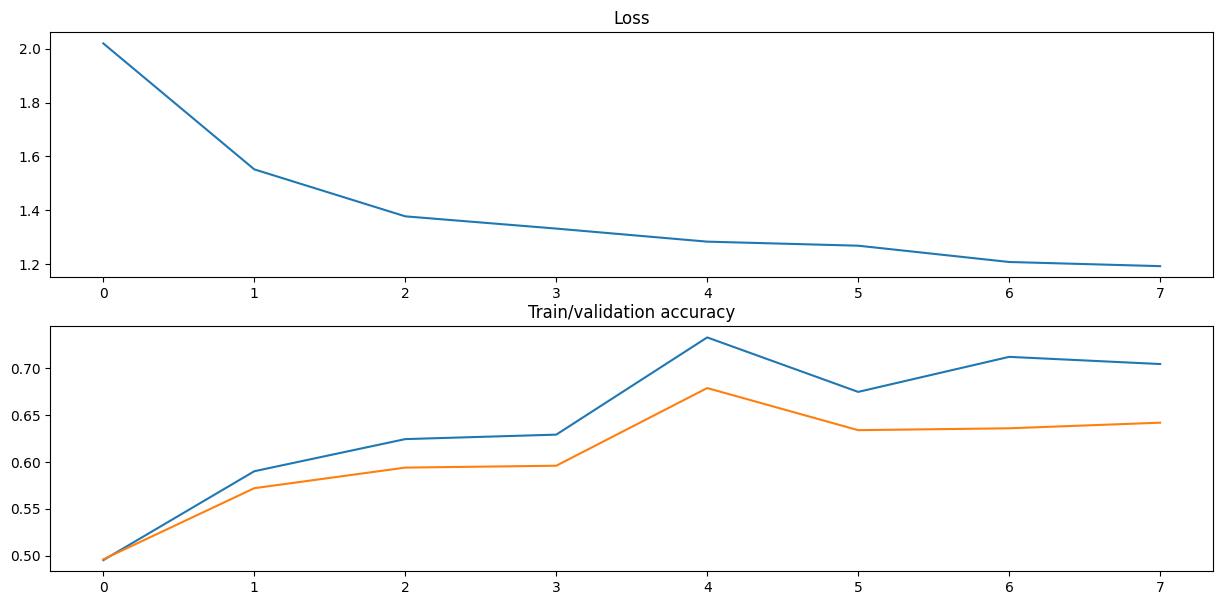

In [16]:
#print(multiclass_accuracy(model.predict(val_X), val_y))
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [20]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.559000
